### This Lab presents methods MUSIC and ESPRIT method to compute coefficients of a signal based on line spectrum model for a bell sound :

$$ s(t) = \sum_{k=0}^{K-1} \alpha _k z_k^t$$ 

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,data.reshape(len(data)))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [4]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('ClocheB.WAV')

In [6]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

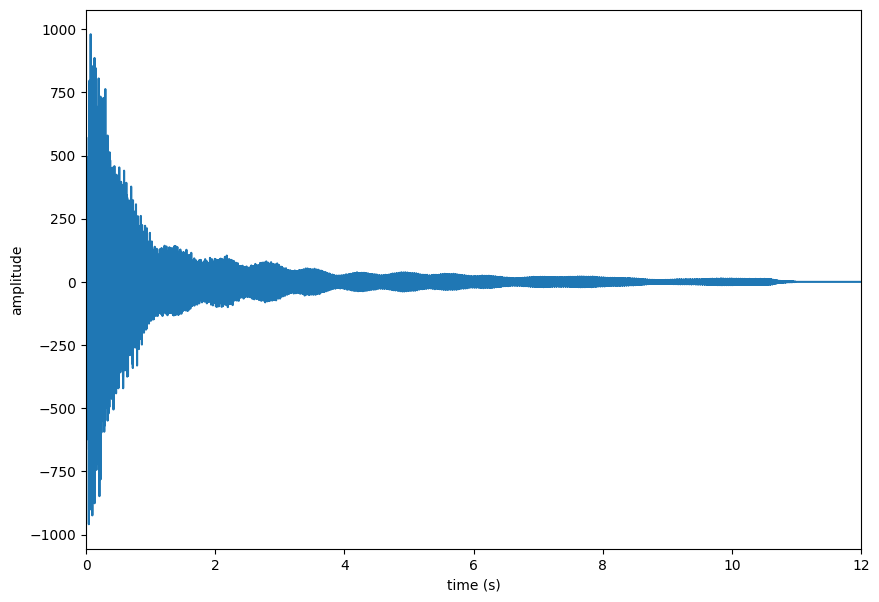

In [7]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [8]:
write(os.getcwd()+'/new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

#  3. Synthetic signal

### 3.1 Spectral Fourier Analysis



c:\Users\fanto\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


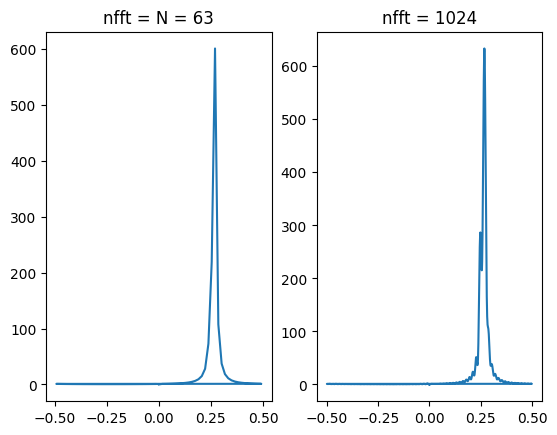

In [9]:
from scipy.signal import periodogram
N = 63
f0 =1/4
f1 = f0 +1/N
f=[f0,f1]
a = [1,10]
delta=[0, -0.05]
phi=[0,0]
x=np.zeros(N,dtype='complex128')
for i in range(len(f)):
    x+=Synthesis(N,delta[i],f[i],a[i],phi[i])
f1,S1=periodogram(x,nfft=N)
f2,S2=periodogram(x,nfft=1024)
plt.subplot(1,2,1)
plt.plot(f1,S1)
plt.title('nfft = N = 63')
plt.subplot(1,2,2)
plt.plot(f2,S2)
plt.title('nfft = 1024')
plt.show()

#We see that we can only distingish the two frequency if nfft > N

In [10]:
#1
def empirical_cov(X):
    return 1/len(X[0])*X@np.transpose(np.conj(X))

#2
def signal_subspace(Rxx,K):
    U1,D,U2=np.linalg.svd(Rxx)
    return np.transpose(U2[:K])

def noise_subspace(Rxx,K,n):
    U1,D,U2=np.linalg.svd(Rxx)
    return np.transpose(U2[K:n])

# 3.1 ESPRIT Method


In [11]:
#3 ESPRIT METHOD
import cmath
n=32
K=2
def Esprit(x,n,K):
    H=hankel(x[:n+1],x[n:])
    Rxx=empirical_cov(H)
    W=signal_subspace(Rxx,K)
    W_down=W[:len(W)-1]
    W_up=W[1:]
    phi=np.linalg.pinv(W_up)@W_down
    z,_=np.linalg.eig(phi)
    delta=np.log(np.abs(z))
    f=np.array([cmath.phase(zk)/(2*np.pi) for zk in z])
    return z,np.flip(delta),np.flip(f)

#4
def LeastSquares(x,delta,f):
    N=len(x)
    v=np.array([delta[k]+2j*np.pi*f[k] for k in range(len(f))]).reshape(1,-1)
    t=np.array(range(N)).reshape(-1,1)
    V=np.exp(t@v)
    alpha=np.linalg.pinv(V)@x
    return np.abs(alpha),np.angle(alpha)

x=np.zeros(N,dtype='complex128')
for i in range(len(f)):
    x+=Synthesis(N,delta[i],f[i],a[i],phi[i])

z_app,delta_app,f_app=Esprit(x,n,K)
a_app,phi_app=LeastSquares(x,delta,f_app)

print('Approximated frequency :',f_app,'Theoretical frequency :',f)
print('Approximated damping factor :',delta_app,'Theoretical damping factor :',delta)
#The error on phi_app and a_app is only caused by delta_app[0] not being equal to zero (found it after multiple testing). Python is doing weird thing here
#Replace delta_app by delta in LeastSquares(x,delta_app,f_app) to see the difference.
print('Approximated phase :',phi_app,'Theoretical phase :',phi)
print('Approximated amplitude :',a_app,'Theoretical amplitude :',a)


Approximated frequency : [0.25       0.26587302] Theoretical frequency : [0.25, 0.26587301587301587]
Approximated damping factor : [-3.33066907e-16  5.00000000e-02] Theoretical damping factor : [0, -0.05]
Approximated phase : [ 9.92261828e-16 -5.82867088e-17] Theoretical phase : [0, 0]
Approximated amplitude : [ 1. 10.] Theoretical amplitude : [1, 10]


3.2.2 MUSIC Method

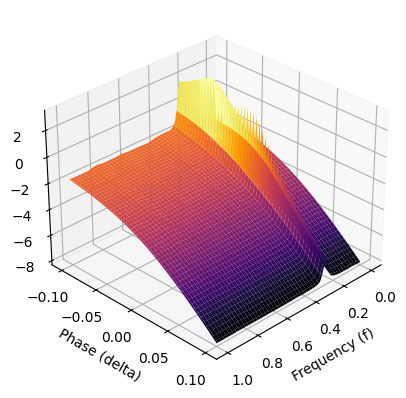

In [12]:
#6
def MUSIC(x,n,K):
    '''
    Implementation of MUSIC method using K components ,for a signal x 
    '''
    H=hankel(x[:n+1],x[n:])
    Rxx=empirical_cov(H)
    WN=noise_subspace(Rxx,K,n)
    log_P= lambda f,delta : -2*np.log(np.linalg.norm(np.transpose(np.conj(WN))@np.array([np.exp(k*(-2j*np.pi*f+delta)) for k in range(n+1)],dtype='complex128')))
     # Generate mesh grid
    f_list = np.linspace(0, 1, 100)
    delta_list = np.linspace(-0.1, 0.1, 100)
    f_mesh, delta_mesh = np.meshgrid(f_list, delta_list)

    # Calculate log_P for each combination of f and delta
    log_P_mesh = np.array([[log_P(f, delta) for f in f_list] for delta in delta_list])

    # Plot surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(f_mesh,delta_mesh, log_P_mesh, cmap='inferno')
    # Rotate the axes
    ax.view_init(elev=30, azim=45)

    # Customize labels
    ax.set_xlabel('Frequency (f)')
    ax.set_ylabel('Phase (delta)')
    ax.set_zlabel('Log Likelihood')

    
    plt.show()
    return 

MUSIC(x,n,K)
#We see that delta are well approximated here but for the frequency it is quite quite hard to distingish them

# 4. Audio signal

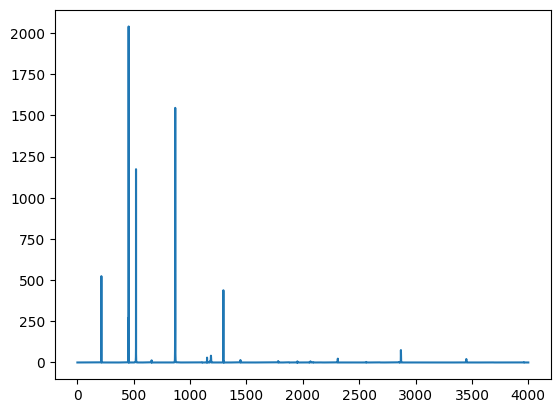

In [13]:
#4.1
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
f,S=periodogram(x,fs=Fs)
S=S.reshape((len(S[0])))
plt.plot(f,S)

#We see that the bell is enharmonic

In [14]:
#4.2
K = 54
n = 512
l = 1024
n = 1024//2
N = 1535
start=10000
x_extract=np.array(x[0][start:start+N])
z_app,delta_app,f_app=Esprit(x_extract,n,K)
a_app,phi_app=LeastSquares(x,delta_app,f_app)
x_synth=np.zeros(N,dtype='complex128')
for i in range(len(f_app)):
    x_synth+=Synthesis(N,delta_app[i],f_app[i],a_app[i],phi_app[i])

write(os.getcwd()+'/new_bell.wav', Fs, np.array(np.real(x_synth).reshape((N, 1)), dtype=np.int16)) # to write a new wave file, may take some time